In [1]:
import nltk
from nltk.corpus import stopwords
# Download NLTK stopwords data 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hygumm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv("/home/hygumm/walshhadamard/974_sentences.csv")

In [14]:
df['explicit_sentences'].isnull().sum()

0

In [15]:
df = df.dropna()

In [16]:
df['explicit_sentences'].isnull().sum()

0

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
def remove_stopwords(sentence):
    tokenized_sentence = sentence.split()
    filtered_sentence = [word for word in tokenized_sentence if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

df['Sentence'] = df['explicit_sentences'].apply(remove_stopwords)

In [19]:
df

,explicit_sentences,pred,Sentence
0,sleepiness can even result in automobile accid...,1.0,sleepiness even result automobile accidents
1,a famed and inflammatory orator he led a numbe...,1.0,famed inflammatory orator led number union str...
2,urushiol induced contact dermatitis is the all...,1.0,urushiol induced contact dermatitis allergic r...
3,large quantities of vitamin e or consuming thi...,1.0,large quantities vitamin e consuming vitamin b...
4,incomplete digestion of insulin fragments may ...,1.0,incomplete digestion insulin fragments may lea...
...,...,...,...
968,boys under 17 (youth)girls under 17 (youth)med...,0.0,boys 17 (youth)girls 17 (youth)medal table (un...
969,√äFrank Licari:√ä Okay.,0.0,√äFrank Licari:√ä Okay.
970,it was built in 1906√¢‚Ç¨‚Äú07 as a five-story...,0.0,built 1906√¢‚Ç¨‚Äú07 five-story building desig...
971,√äYou have to be careful what you take to the ...,0.0,√äYou careful take market.


In [20]:
df

,explicit_sentences,pred,Sentence
0,sleepiness can even result in automobile accid...,1.0,sleepiness even result automobile accidents
1,a famed and inflammatory orator he led a numbe...,1.0,famed inflammatory orator led number union str...
2,urushiol induced contact dermatitis is the all...,1.0,urushiol induced contact dermatitis allergic r...
3,large quantities of vitamin e or consuming thi...,1.0,large quantities vitamin e consuming vitamin b...
4,incomplete digestion of insulin fragments may ...,1.0,incomplete digestion insulin fragments may lea...
...,...,...,...
968,boys under 17 (youth)girls under 17 (youth)med...,0.0,boys 17 (youth)girls 17 (youth)medal table (un...
969,√äFrank Licari:√ä Okay.,0.0,√äFrank Licari:√ä Okay.
970,it was built in 1906√¢‚Ç¨‚Äú07 as a five-story...,0.0,built 1906√¢‚Ç¨‚Äú07 five-story building desig...
971,√äYou have to be careful what you take to the ...,0.0,√äYou careful take market.


In [23]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, sentences, labels, word_to_index):
        self.sentences = sentences
        self.labels = labels
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        indexed_sentence = [self.word_to_index[word] for word in sentence.split()]
        return torch.tensor(indexed_sentence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Tokenization and Vocabulary
sentences = df['Sentence'].tolist()  # Correct column name
labels = df['pred'].values.astype(int)
tokenized_sentences = [sentence.split() for sentence in sentences]
all_tokens = set([token for sentence in tokenized_sentences for token in sentence])
word_to_index = {word: i+1 for i, word in enumerate(all_tokens)}  # Starting index from 1
vocab_size = len(word_to_index) + 1  # +1 for padding index 0

# Dataset and DataLoader
dataset = CustomDataset(sentences, labels, word_to_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Batch size of 1 for individual processing

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model Initialization
embedding_dim = 300
hidden_dim = 64
output_dim = 2  # Since you have two classes
model = LSTMModel(embedding_dim, hidden_dim, output_dim, vocab_size)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Assuming you have defined model, criterion, dataloader
for inputs, labels in dataloader:
    # Reset gradients
    model.zero_grad()
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # Backward pass
    loss.backward()
    
    # Accessing the gradient of the output with respect to the embeddings
    embedding_gradients = model.embedding.weight.grad[inputs].squeeze(0)
    importance_scores = embedding_gradients.abs().sum(dim=1).tolist()
    
    print(f"Importance scores for the sentence: {importance_scores}")

Importance scores for the sentence: [0.10628343373537064, 0.18192794919013977, 0.295231431722641, 0.6295133829116821, 1.50167977809906]
Importance scores for the sentence: [0.007496376521885395, 0.01809990219771862, 0.026219194754958153, 0.03674622252583504, 0.0437353141605854, 0.08232095092535019, 0.20660829544067383, 0.27275770902633667, 0.7347309589385986, 1.4355026483535767]
Importance scores for the sentence: [0.006934227421879768, 0.012930507771670818, 0.023670587688684464, 0.10515102744102478, 0.11707447469234467, 0.2374466210603714, 0.42615973949432373, 0.7837868332862854, 1.3096668720245361]
Importance scores for the sentence: [0.0005887746810913086, 0.0010593192419037223, 0.012357134371995926, 0.0034354280214756727, 0.0053057982586324215, 0.012357134371995926, 0.28601711988449097, 0.037486251443624496, 0.060589879751205444, 0.11323034018278122, 0.19298532605171204, 0.28601711988449097, 0.6230589151382446, 1.5704269409179688]
Importance scores for the sentence: [0.000695894239

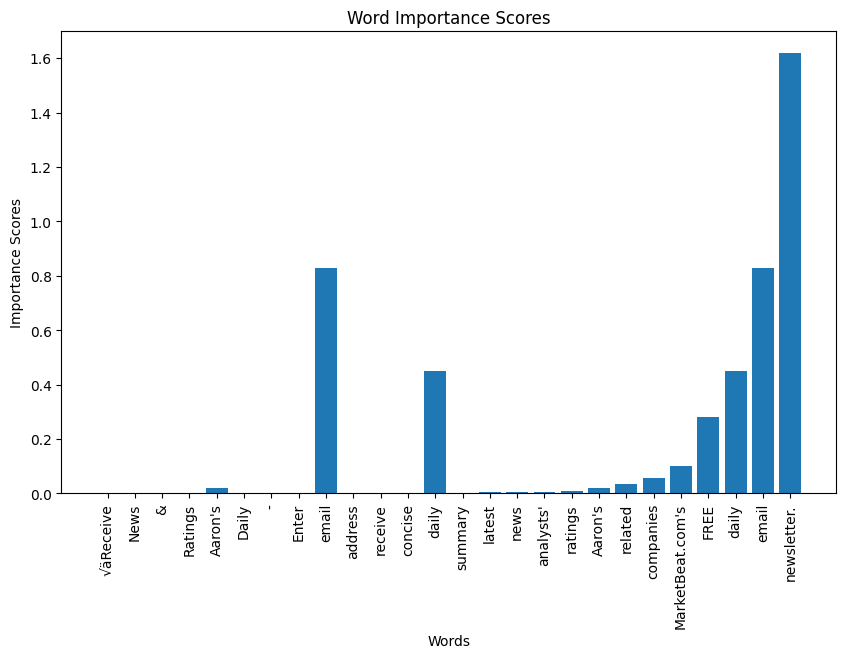

In [36]:
import matplotlib.pyplot as plt

# Define a function to plot importance scores
def plot_importance_scores(sentence, importance_scores):
    words = sentence.split()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(words)), importance_scores, align='center')
    plt.xticks(range(len(words)), words, rotation='vertical')
    plt.xlabel('Words')
    plt.ylabel('Importance Scores')
    plt.title('Word Importance Scores')
    plt.show()

# Choose a sentence index to visualize
sentence_index = 500  # for example, change this to your specific index

# Model, Criterion, and DataLoader initialization code goes here...

# Process and plot importance scores for the specified sentence
for i, (inputs, labels) in enumerate(dataloader):
    if i == sentence_index:
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Accessing the gradient of the output with respect to the embeddings
        embedding_gradients = model.embedding.weight.grad[inputs].squeeze(0)
        importance_scores = embedding_gradients.abs().sum(dim=1).tolist()

        # Now, plot the importance scores for the chosen sentence
        sentence = sentences[sentence_index]
        plot_importance_scores(sentence, importance_scores)
        break


In [37]:
df['Sentence'][500]

"√äReceive News & Ratings Aaron's Daily - Enter email address receive concise daily summary latest news analysts' ratings Aaron's related companies MarketBeat.com's FREE daily email newsletter."